## 모델 개선
- 과대적합 방지 - 학습 파라미터 수 축소
- 모델 성능 높이기 - 레이어 추가
- 모델 성능 높이기 - 이미지 증식

- SpatialDropout2D: 2D 공간에서 특정 뉴런을 무작위로 드롭아웃합니다.
- ReduceLROnPlateau: 학습 성능이 개선되지 않을 경우 학습률을 동적으로 감소시킵니다.
- ImageDataGenerator: 이미지 데이터를 실시간으로 증강(augmentation)시키는 클래스입니다. 데이터 양을 늘리고 과적합을 방지하기 위해 이미지 회전, 확대, 축소 등의 변환을 수행할 수 있습니다.

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, SpatialDropout2D, Flatten, Reshape, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# 데이터 로드
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 이미지 데이터에 채널 차원이 명시적으로 없는 경우(예: (28, 28) 크기의 이미지) 채널 차원을 추가
x_train = x_train[..., np.newaxis]  # (28, 28) -> (28, 28, 1)
x_test = x_test[..., np.newaxis]

# 이미지 데이터 정규화 (픽셀 값을 0~1 범위로 변환)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 데이터 셰이프 출력
print(x_train.shape)  # (60000, 28, 28, 1)
print(y_train.shape)  # (60000,)
print(x_test.shape)   # (10000, 28, 28, 1)
print(y_test.shape)   # (10000,)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
class_names = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

In [4]:
# 모델 구성 및 컴파일
def build_model():
  # model=Sequential()
  input = Input(shape=(28,28,1))
  output = Conv2D(filters=32,kernel_size=(3,3))(input)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Flatten()(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(64, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output) # 모델이 하나 이상의 입력을 받을 수 있으며 출력은 단일 출력을 함.

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_1 = build_model()
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,029,706 (15.37 MB)

 Trainable params: 4,029,706 (15.37 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_1 = model_1.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7391 - loss: 0.7620
Epoch 1: val_loss improved from inf to 0.39562, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - acc: 0.7394 - loss: 0.7613 - val_acc: 0.8553 - val_loss: 0.3956
Epoch 2/40
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8709 - loss: 0.3514
Epoch 2: val_loss improved from 0.39562 to 0.37817, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - acc: 0.8709 - loss: 0.3513 - val_acc: 0.8623 - val_loss: 0.3782
Epoch 3/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8949 - loss: 0.2904
Epoch 3: val_loss improved from 0.37817 to 0.33721, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8949 - loss: 0.2904 - val_acc: 0.8789 - val_loss: 0.3372
Epoch 4/40
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9123 - loss: 0.2321
Epoch 4: val_loss did not improve from 0.33721
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc:

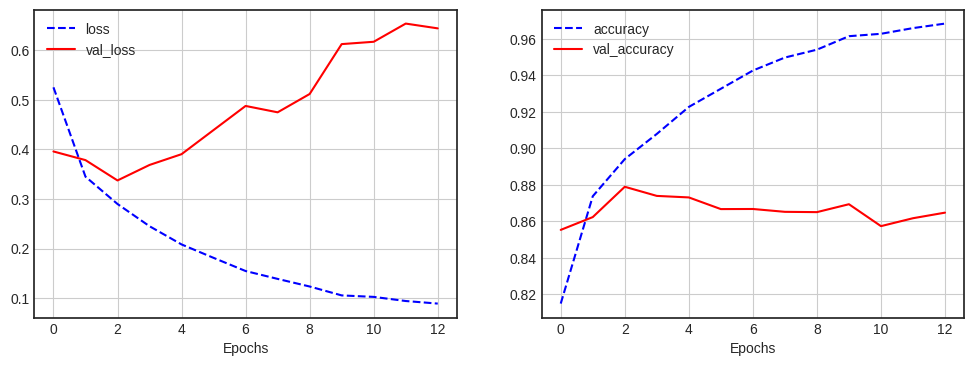

In [6]:
hist_1.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_1.history['loss'],'b--',label='loss')
plt.plot(hist_1.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_1.history['acc'],'b--',label='accuracy')
plt.plot(hist_1.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [7]:
model_1.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.8572 - loss: 0.7149


[0.6972609758377075, 0.8564000129699707]

In [ ]:
!ls

best_model.keras  sample_data


### 모델 구성 및 학습: 과대적합 방지

- 학습 파라미터의 수 비교
  - 모델 1은 더 많은 Conv2D 레이어를 포함하고 있으며, MaxPooling2D 및 Dropout 레이어가 없으므로 학습할 파라미터가 더 많습니다.
  - 모델 2는 Conv2D 레이어 후 MaxPooling2D와 Dropout 레이어를 추가하여 파라미터 수를 줄이는 동시에, 과적합을 방지하는 데 더 신경 쓴 모델입니다.

In [8]:
# 슬림한 모델로 바꾼 결과 과적합은 방지하지만 성능은 좋지 않음
def build_model2():

  input = Input(shape=(28,28,1))
  output = Conv2D(filters=32,kernel_size=(3,3))(input)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Dropout(0.4)(output)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Dropout(0.4)(output)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Flatten()(output)
  output = Dense(128, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(64, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_2 = build_model2()
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,970 (285.04 KB)

 Trainable params: 72,970 (285.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model2.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_2 = model_2.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.4269 - loss: 1.5465
Epoch 1: val_loss improved from inf to 0.71344, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - acc: 0.4273 - loss: 1.5453 - val_acc: 0.7324 - val_loss: 0.7134
Epoch 2/40
323/329 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7224 - loss: 0.7658
Epoch 2: val_loss improved from 0.71344 to 0.62011, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.7226 - loss: 0.7652 - val_acc: 0.7769 - val_loss: 0.6201
Epoch 3/40
315/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7611 - loss: 0.6641
Epoch 3: val_loss improved from 0.62011 to 0.58840, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7612 - loss: 0.6637 - val_acc: 0.7873 - val_loss: 0.5884
Epoch 4/40
321/329 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7791 - loss: 0.6227
Epoch 4: val_loss improved from 0.58840 to 0.51751, saving model to best_model2.keras
329/329 ━━━━

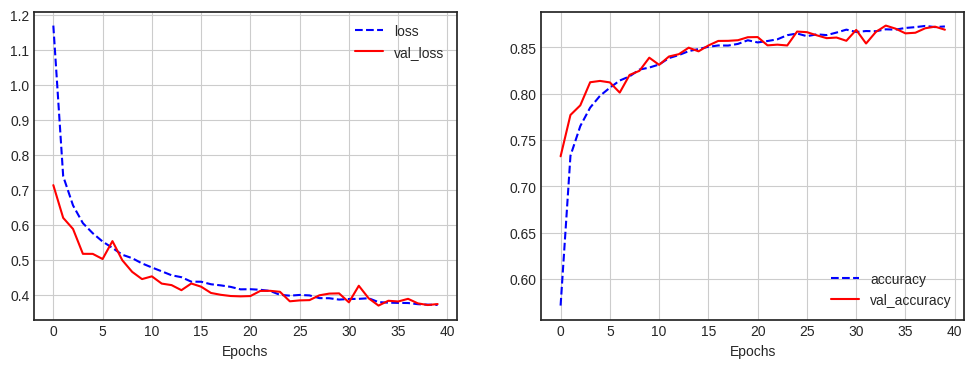

In [10]:
hist_2.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_2.history['loss'],'b--',label='loss')
plt.plot(hist_2.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_2.history['acc'],'b--',label='accuracy')
plt.plot(hist_2.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [11]:
model_2.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8600 - loss: 0.3966


[0.3856261372566223, 0.8598999977111816]

### 모델 성능 높이기: 레이어 추가

padding='same'과 'valid'옵션을 코드 내에서 별도로 설정하는 이유
- 모델 설계자가 네트워크의 각 계층에서 출력의 크기와 특성 추출 방식을 세밀하게 제어하고자 하는 것이다.
- 아래 경우에는 초기에는 공간 차원을 유지하면서 입력 데이터의 전반적인 특성을 포착하고 네트워크가 깊어질 수록 더 추상화된 특성을 추출하려는 목적으로 생각해 볼 수 있음.

In [12]:
def build_model3():

  input = Input(shape=(28,28,1))
  output = Conv2D(filters=64,kernel_size=3, activation='relu',padding='same')(input)
  output = BatchNormalization()(output)
  output = Conv2D(filters=64,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Conv2D(filters=128,kernel_size=3, activation='relu',padding='same')(output)
  output = BatchNormalization()(output)
  output = Conv2D(filters=128,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Conv2D(filters=256,kernel_size=3, activation='relu',padding='same')(output)
  output = BatchNormalization()(output)
  output = Conv2D(filters=256,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_3 = build_model3()
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 1,411,530 (5.38 MB)

 Trainable params: 1,410,634 (5.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model3.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_3 = model_3.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.6117 - loss: 1.1508
Epoch 1: val_loss improved from inf to 2.78711, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - acc: 0.6121 - loss: 1.1497 - val_acc: 0.0983 - val_loss: 2.7871
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8282 - loss: 0.4822
Epoch 2: val_loss improved from 2.78711 to 1.17844, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.8283 - loss: 0.4821 - val_acc: 0.5595 - val_loss: 1.1784
Epoch 3/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8657 - loss: 0.3847
Epoch 3: val_loss improved from 1.17844 to 0.88234, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.8658 - loss: 0.3846 - val_acc: 0.7083 - val_loss: 0.8823
Epoch 4/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8852 - loss: 0.3315
Epoch 4: val_loss improved from 0.88234 to 0.83505, saving model to best_model3.keras
329/329

- 과대적합은 되지 않았고, 층을 늘려도 좋은 성능을 낼 수 있음

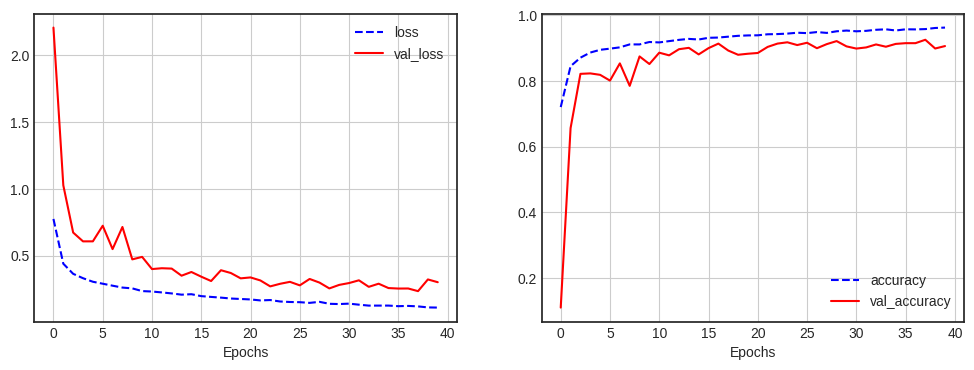

In [ ]:
hist_3.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_3.history['loss'],'b--',label='loss')
plt.plot(hist_3.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_3.history['acc'],'b--',label='accuracy')
plt.plot(hist_3.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model_3.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.8981 - loss: 0.3285


[0.32192498445510864, 0.9003999829292297]

In [ ]:
!ls

best_model2.keras  best_model3.keras  best_model.keras	sample_data


### CNN(Convolutional Neural Network)에서 파라미터 수의 증가 요소

- 필터(커널)의 수: CNN의 각 합성곱 계층(Convolutional layer)은 여러 필터(또는 커널)를 사용하여 입력 이미지에서 특징을 추출합니다. 필터의 수가 많아질수록 더 많은 특징을 동시에 학습할 수 있지만, 이는 동시에 해당 계층의 파라미터 수를 증가시킵니다.

- 필터의 크기: 필터의 크기가 클수록 한 번에 더 넓은 영역의 정보를 처리할 수 있습니다. 그러나 필터 크기의 증가는 필터 내의 가중치 수를 증가시켜, 결과적으로 해당 계층의 전체 파라미터 수를 증가시킵니다.

- 완전연결계층(Fully Connected layers)의 크기: CNN의 끝부분에서 주로 사용되는 전결합 계층은 모든 입력을 각 출력 뉴런에 연결합니다. 이 계층의 뉴런(유닛) 수가 많을수록 모델의 파라미터 수가 크게 증가합니다. 전결합 계층은 일반적으로 모델 내에서 가장 많은 파라미터를 가집니다.

- 계층의 깊이: CNN의 계층(레이어) 수가 많아질수록, 즉 모델이 더 깊어질수록, 모델이 더 복잡한 특징을 학습할 수 있게 되지만, 이는 또한 전체 파라미터 수를 증가시킵니다.

- 특성 맵(Feature Map)의 크기: 특정 합성곱 계층이 출력하는 특성 맵의 크기가 크면 클수록, 그 다음 계층(특히 전결합 계층이나 합성곱 계층)의 파라미터 수가 증가할 수 있습니다. 특성 맵의 크기는 입력 이미지의 크기와 필터의 크기, 스트라이드(stride), 패딩(padding)에 의해 결정됩니다.

이러한 요소들은 모두 모델의 학습 능력과 일반화 능력에 영향을 미칩니다. 파라미터 수가 많은 모델은 더 복잡한 특징을 학습할 수 있지만, 과적합(overfitting)의 위험도 높아질 수 있습니다. 반면, 파라미터 수가 적은 모델은 계산 효율성은 높지만, 모델의 표현 능력이 제한될 수 있습니다. 따라서 모델 설계 시 이러한 점을 고려하여 적절한 균형을 찾는 것이 중요합니다.

### 모델 성능 높이기: 이미지 증강(Image Augmentation)
데이터 증강은 기존의 훈련 데이터를 다양하게 변형하여 모델의 일반화 능력을 향상시키는 기법입니다. 각 파라미터는 특정 방식으로 이미지를 변형합니다.

ImageDataGenerator 파라미터 설명:
- rotation_range=10: 이미지를 -10도에서 10도 사이로 무작위로 회전합니다.
- zoom_range=0.2: 이미지를 80%에서 120% 사이로 무작위로 확대/축소합니다.
- shear_range=0.6: 이미지를 반시계 방향으로 0.6 라디안 내에서 기울입니다.
- width_shift_range=0.1와 height_shift_range=0.1: 각각 이미지를 수평과 수직으로 최대 10% 내에서 무작위로 이동합니다.
- horizontal_flip=True: 수평 방향으로 이미지를 무작위로 뒤집습니다. (예: 좌우 반전)
- vertical_flip=False: 수직 방향으로 이미지를 뒤집지 않습니다.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [15]:
image_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augment_size = 200 # 데이터 증강을 통해 생성하고자 하는 증강된 이미지의 수
print(x_train.shape)
print(x_train[0].shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [18]:
# flow 메소드는 실제로 이미지 데이터를 변환하는 작업을 수행
# np.tile(x_train[0].reshape(28*28*1),augment_size).reshape(-1,28,28,1)은 첫 번째 훈련 이미지(x_train[0])를 augment_size(200)만큼 복제하여 증강된 이미지 데이터의 형태로 변환.
# np.zeros(augment_size)는 증강된 이미지에 대한 레이블을 생성
# batch_size=augment_size는 한 번에 생성할 증강된 이미지의 수를 지정
# next()[0]을 통해 생성된 이미지 배치 중 첫 번째 배치(즉, 증강된 이미지들)에 접근
# 이미지 증강
x_augment_iterator = image_generator.flow(
    np.repeat(x_train[0].reshape(1, 28, 28, 1), augment_size, axis=0),  # 이미지 복제 후 증강
    np.zeros(augment_size),  # 라벨은 필요하지 않으므로 0으로 채운다
    batch_size=augment_size,
    shuffle=False
)

# next()를 호출하여 첫 번째 배치 가져오기
# [0]: flow()로 반환된 데이터는 (이미지 데이터, 라벨 데이터) 형식으로 반환되기 때문에, [0]을 사용하여 이미지 데이터만 추출
x_augment = next(x_augment_iterator)[0]

print(x_augment.shape)  # 증강된 이미지의 형상을 확인

(200, 28, 28, 1)


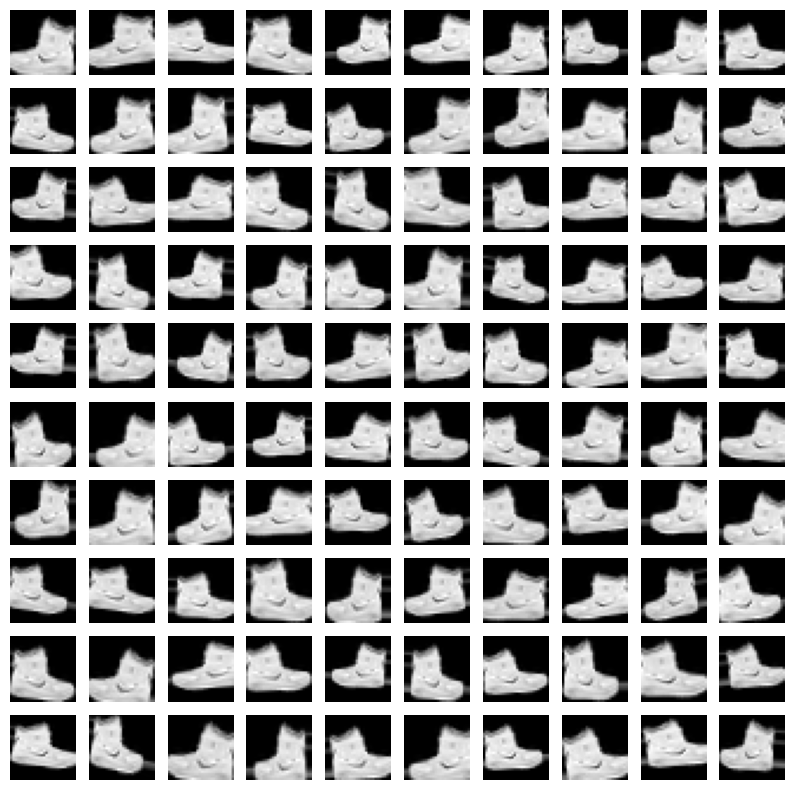

In [17]:
plt.figure(figsize=(10,10))
for i in range(1,101):
  plt.subplot(10,10,i)
  plt.axis('off')
  plt.imshow(x_augment[i-1].reshape(28,28),cmap='gray')

In [19]:
image_generator = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.6,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augment_size = 30000
random_mask = np.random.randint(x_train.shape[0],size=augment_size) # 증강할 이미지들의 인덱스 선정
x_augmented = x_train[random_mask].copy()
y_augmented = y_train[random_mask].copy()

In [20]:
# 증강할 이미지 생성기 설정
x_augmented = image_generator.flow(
    x_augmented,  # 증강할 이미지
    np.zeros(augment_size),  # 라벨은 필요하지 않으므로 0으로 설정
    batch_size=augment_size,
    shuffle=False
)

# 첫 번째 배치 가져오기
x_augmented = next(x_augmented)[0]

# 증강된 이미지의 형상 확인
print(x_augmented.shape)

(30000, 28, 28, 1)


In [21]:
x_augmented.shape

(30000, 28, 28, 1)

In [22]:
x_train = np.concatenate((x_train,x_augmented))
y_train = np.concatenate((y_train,y_augmented))
print(x_train.shape)
print(y_train.shape)

(90000, 28, 28, 1)
(90000,)


In [23]:
model_4 = build_model3()
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 1,411,530 (5.38 MB)

 Trainable params: 1,410,634 (5.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [24]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model4.keras', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_4 = model_4.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.6385 - loss: 1.0444
Epoch 1: val_loss improved from inf to 2.05696, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - acc: 0.6388 - loss: 1.0437 - val_acc: 0.2685 - val_loss: 2.0570
Epoch 2/40
491/493 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8482 - loss: 0.4310
Epoch 2: val_loss improved from 2.05696 to 1.27201, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - acc: 0.8482 - loss: 0.4309 - val_acc: 0.5487 - val_loss: 1.2720
Epoch 3/40
492/493 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8750 - loss: 0.3557
Epoch 3: val_loss improved from 1.27201 to 1.22858, saving model to best_model4.keras
493/493 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - acc: 0.8750 - loss: 0.3557 - val_acc: 0.6931 - val_loss: 1.2286
Epoch 4/40
491/493 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8862 - loss: 0.3269
Epoch 4: val_loss did not improve from 1.22858
493/493 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step -

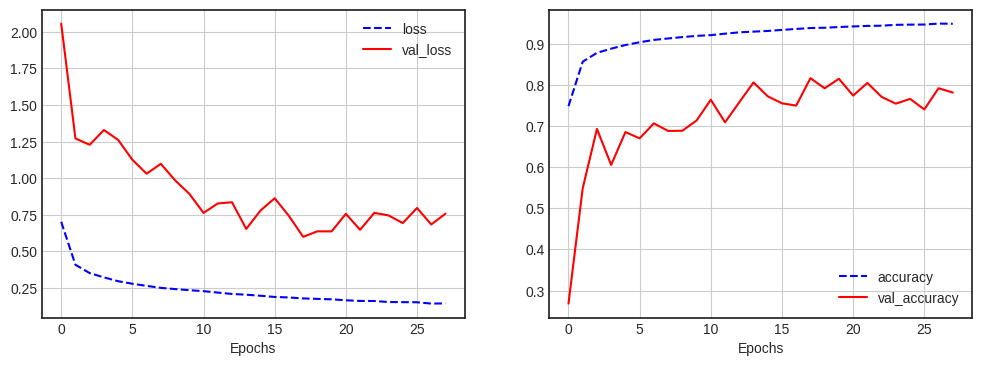

In [25]:
hist_4.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_4.history['loss'],'b--',label='loss')
plt.plot(hist_4.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_4.history['acc'],'b--',label='accuracy')
plt.plot(hist_4.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [26]:
model_4.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.9257 - loss: 0.2640


[0.25828367471694946, 0.9254999756813049]

# 합성곱 신경망의 시각화

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42) # TensorFlow의 난수 생성기에 대한 글로벌 랜덤 시드를 설정
# tf.config.experimental.enable_op_determinism() # TensorFlow가 가능한 한 결정적인 연산을 사용하도록 강제

## 가중치 시각화

In [ ]:
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# local 폴더에서 가져오는 경우
# from google.colab import files
# files.upload()

{}

In [ ]:
!ls

best-cnn-model.h5  drive  sample_data


In [ ]:
# 코랩에서 실행하는 경우에는 다음 명령을 실행하여 best-cnn-model.h5 파일을 다운로드받아 사용하세요.
# !wget https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5

--2023-11-11 04:03:47--  https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5 [following]
--2023-11-11 04:03:48--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4046712 (3.9M) [application/octet-stream]
Saving to: ‘best-cnn-model.h5’

best-cnn-model.h5   100%[===================>]   3.86M  --.-KB/s    in 0.06s   

2023-11-11 04:03:48 (60.6 MB/s) - ‘best-cnn-model.h5’ saved [4046712/4046712]



In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/kdt_231026/m8_vision/best-cnn-model.h5')

In [ ]:
model.layers

In [ ]:
# 신경망 모델의 첫 번째 레이어(여기서는 합성곱 레이어를 가정)의 가중치(weights)와 편향(biases)의 형태(shape)를 확인
# 편향은 각 출력 채널에 대해 하나씩, 총 32개가 존재
conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape) # (높이, 너비, 입력 채널 수, 출력 채널 수) (출력 채널 수,)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
# 모델의 초기화 상태를 평가하거나, 훈련 과정 중 가중치 값들이 어떻게 변화하는지 관찰하는 데 유용할 수 있습니다.
# 예를 들어, 가중치의 초기화가 너무 작거나 큰 값을 가지면, 학습 과정에 부정적인 영향을 미칠 수 있습니다.
print(conv_weights.mean(), conv_weights.std())

-0.020210389 0.24528325


In [ ]:
import matplotlib.pyplot as plt

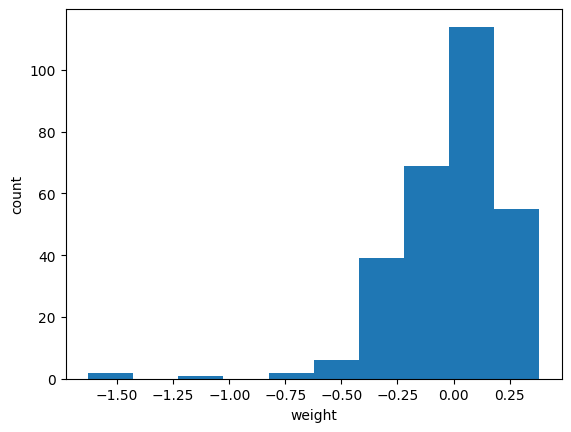

In [ ]:
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

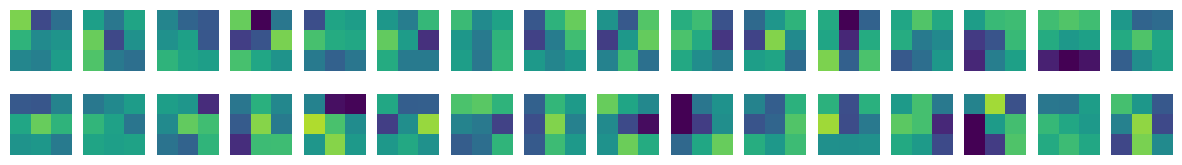

In [ ]:
# 첫번째 layer의 가중치를 시각화
# 합성곱 레이어의 첫 번째 입력 채널에 대한 모든 필터를 2행 16열의 격자 형태로 시각화, 각 필터가 어떤 특징을 감지하도록 학습되었는지 직관적으로 이해할 수 있게한다.
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
      # vmin=-0.5, vmax=0.5 색상 맵에 사용될 데이터의 값 범위를 지정. 가중치 값의 범위를 -0.5에서 0.5로 설정하여 시각화의 색상 대비를 조절
      # i*16 + j는 출력 채널(또는 필터)의 인덱스를 계산하는 부분
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # (높이, 너비, 입력 채널 수, 출력 채널 수)
        axs[i, j].axis('off')

plt.show()

시각화 결과로 부터 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있다. 예를들어 밝은 부분의 값이 높으며 이 가중치는 오른쪽에 놓인 직선을 만나면 크게 활성화 될 수 있다.

In [ ]:
# 가중치가 초기화된 상태이지만 아직 학습되지 않은 새로운 합성곱 신경망 모델을 생성하고,
# 이 모델에 첫 번째 레이어로 합성곱 레이어(Conv2D)를 추가하는 과정
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

In [ ]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

-0.010310263 0.0773888


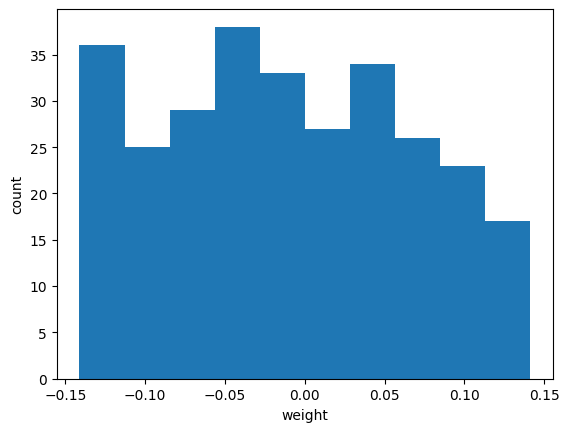

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

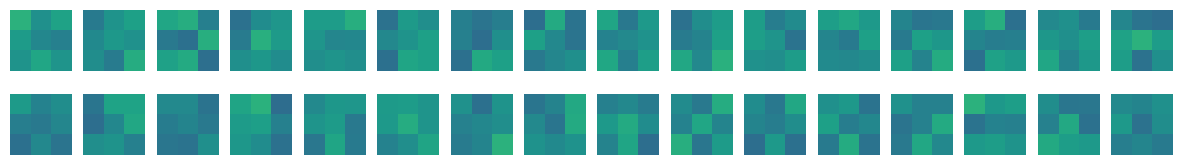

In [ ]:
# 전체적으로 가중치가 밋밋하게 초기화
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

학습을 거친 이전 가중치와 비교하면 합성곱 신경만이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 확인할 수 있다.